https://otexts.com/fpp3/

Focusing on SPY only for now

In [57]:
# Import libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from datetime import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta
from sklearn.metrics import mean_absolute_error
from helper import perform_adf_test, transform_data, split_data, undo_transformations, evaluate_model

In [58]:
# Get tickers we are interested in
tickers = ['SPY', 'VOO', 'NASDX', 'QQQ', 'DIA'] # common etfs (https://www.bankrate.com/investing/best-index-funds/#NASDX)
#test_tickers = ['BTC-USD']
NUM_TICKERS = len(tickers)

# Set start and end dates that specify the amount of data we will pull
START_DATE = datetime.today() + relativedelta(years=-3)
END_DATE = datetime.today()

# Pull data using API
data = yf.download(tickers, start=START_DATE, end=END_DATE)['Adj Close']

spy_data = yf.download('SPY', start = START_DATE, end =END_DATE)['Adj Close']

[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  1 of 1 completed


In [59]:
# Checking for null values
data.isna().sum()

Ticker
DIA      0
NASDX    0
QQQ      0
SPY      0
VOO      0
dtype: int64

In [60]:
# Get data into long format so we can visualize it
long_data = pd.melt(data.reset_index(), id_vars = ['Date'], value_vars = tickers)

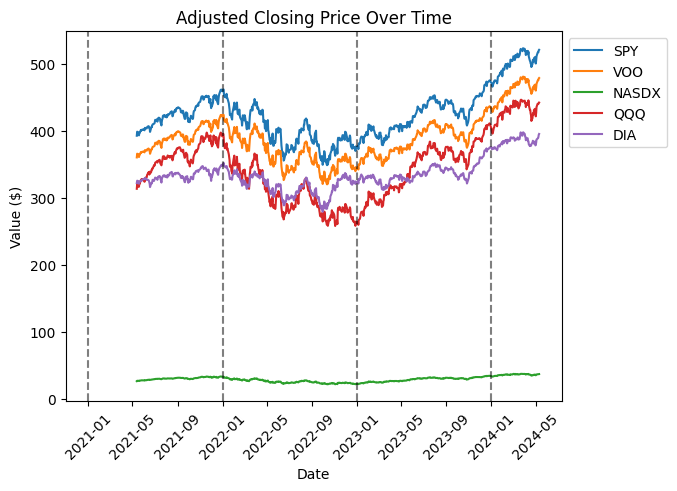

In [61]:
# Time Series Plots
sns.lineplot(data = long_data, x = 'Date', y = 'value', hue = 'Ticker');
plt.title('Adjusted Closing Price Over Time');
plt.xticks(rotation = 45);
plt.ylabel('Value ($)');
plt.legend(loc = 'upper left', bbox_to_anchor=(1, 1));
for year in range(data.index.min().year, data.index.max().year+1):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)
    

EDA on SPY

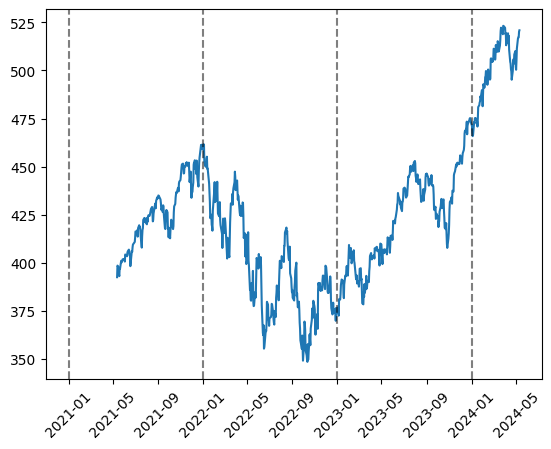

In [62]:
plt.plot(spy_data);
for year in range(spy_data.index.min().year, spy_data.index.max().year+1):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)
plt.xticks(rotation = 45);

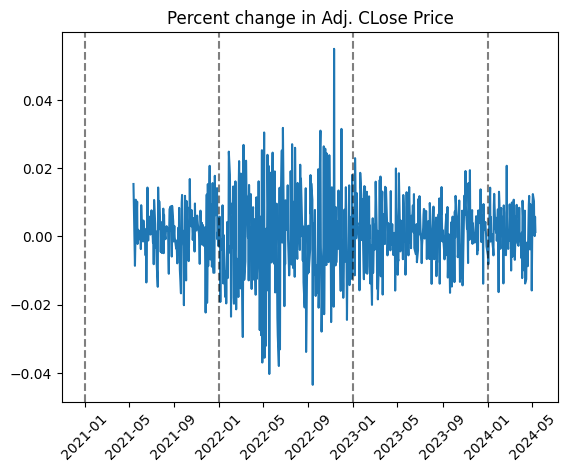

In [63]:
plt.plot(spy_data.pct_change());
for year in range(spy_data.index.min().year, spy_data.index.max().year+1):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)
plt.xticks(rotation = 45);
plt.title('Percent change in Adj. CLose Price');

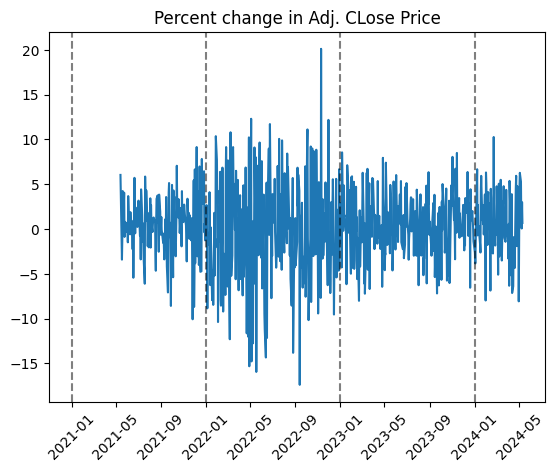

In [64]:
plt.plot(spy_data.diff(periods=1));
for year in range(spy_data.index.min().year, spy_data.index.max().year+1):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)
plt.xticks(rotation = 45);
plt.title('Percent change in Adj. CLose Price');

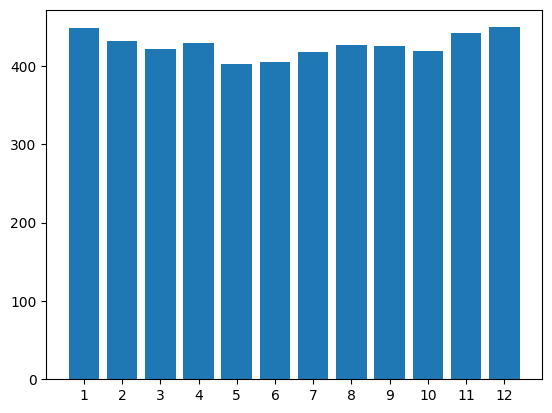

In [65]:
price_by_month = spy_data.groupby(spy_data.index.month).median() 
plt.xticks(range(1, 13))
plt.bar(price_by_month.index, price_by_month);

How does this compare to Bitcoin and Coinbase?

In [66]:
crypto_equities_tickers = ['SPY', 'VOO', 'NASDX', 'QQQ', 'DIA', 'BTC', 'COIN'] 

crypto_equities = yf.download(crypto_equities_tickers, start=START_DATE, end=END_DATE)['Adj Close']

[*********************100%%**********************]  7 of 7 completed


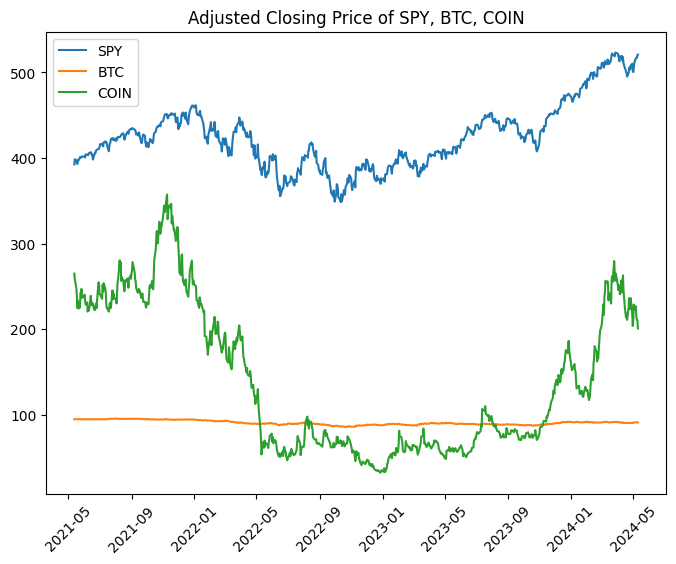

In [67]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))
ax.plot(crypto_equities['SPY']);
ax.plot(crypto_equities['BTC']);
ax.plot(crypto_equities['COIN']);
plt.title('Adjusted Closing Price of SPY, BTC, COIN');
#plt.xlim(data.index.min(), date.today());
plt.xticks(rotation = 45);
ax.legend(labels = ['SPY', 'BTC', 'COIN'], loc = 'upper left');

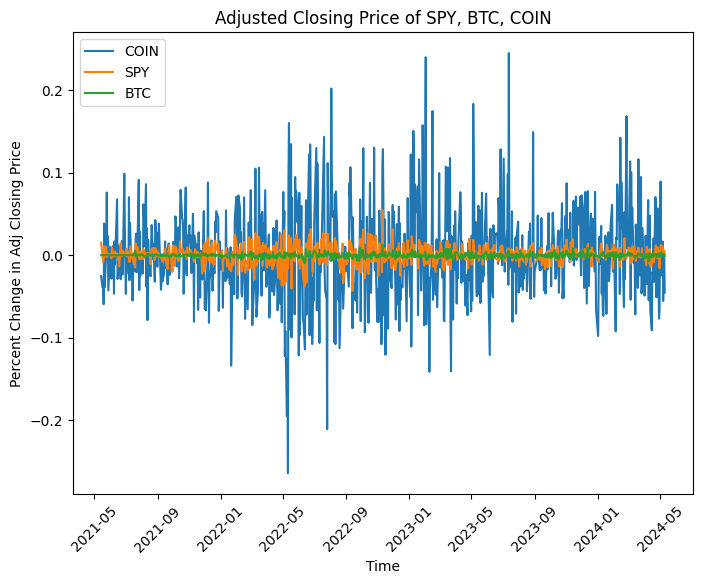

In [68]:
# Returns
returns = crypto_equities.pct_change().dropna()

fig, ax = plt.subplots(1, 1, figsize = (8, 6))
ax.plot(returns['COIN']);
ax.plot(returns['SPY']);
ax.plot(returns['BTC']);
plt.title('Adjusted Closing Price of SPY, BTC, COIN');
#plt.xlim(datetime(2020, 10, 1), date.today());
plt.xticks(rotation = 45);
plt.ylabel('Percent Change in Adj Closing Price');
plt.xlabel('Time')
ax.legend(labels = ['COIN', 'SPY', 'BTC'], loc = 'upper left');

Other vizs to try: lagplots

Autocorrelation is the correlation between lagged values of a time series. e.g. You can measure the autocorrelation of the price of Bitcoin today and the price 2 days ago.

Important Note: Autocorrelation takes into the account both the indirect and direct effects that the price 2 days ago had on today's price. An example of an indirect effect is the price 2 days ago affected the price 1 day ago which affected the price today.

If we wanted to only measure direct effect we can use the PACF (Partial Autocorrelation Function).

for more info(https://www.youtube.com/watch?v=DeORzP0go5I&t=465s)

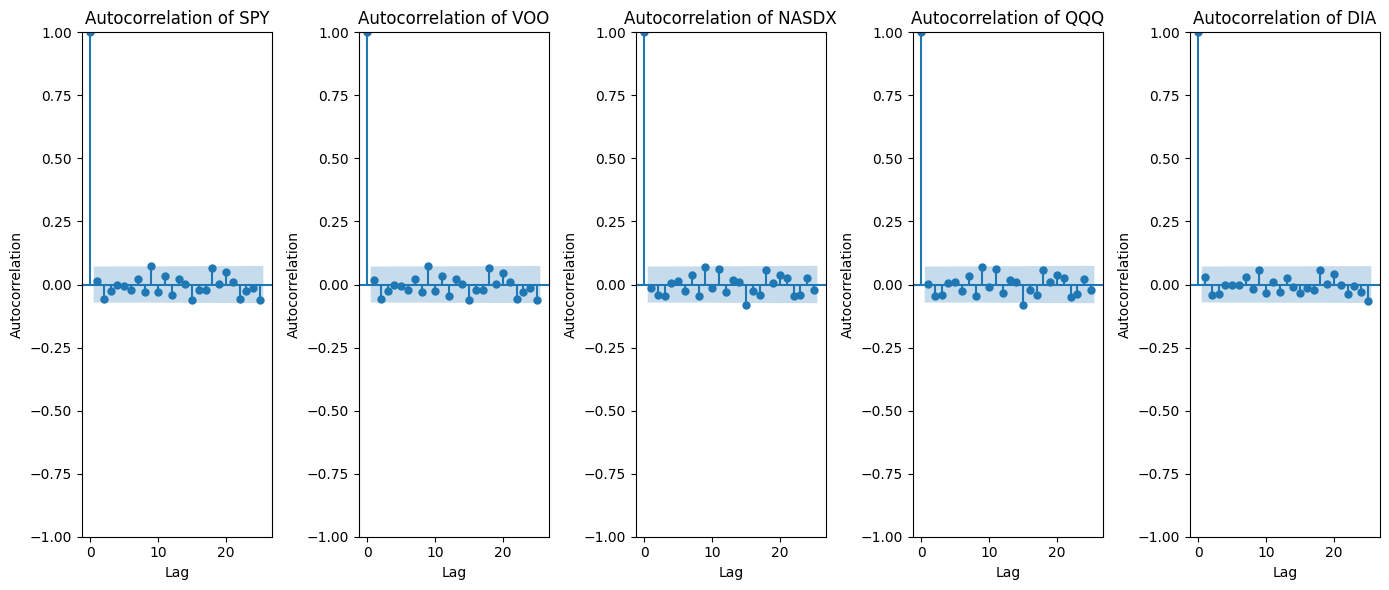

In [69]:
# ACF plots
fig, ax = plt.subplots(1, NUM_TICKERS, figsize=(14, 6))

# first difference makes the data have stationarity so we can create the ACF and PACF plots, which is why we plot the first difference

for i, ticker in enumerate(tickers):
  plot_acf(data[ticker].diff(periods=1).dropna(), ax = ax[i], lags = 25) #.diff() calculates the first difference
  ax[i].set(title = f'Autocorrelation of {ticker}', xlabel = 'Lag', ylabel = 'Autocorrelation')

plt.tight_layout()
plt.show()

The ACF plot tells us how correlated today's price is with the kth previous day's price. We are looking for points outside the blue band. Disregard x = 0 because that is the correlation of today's price with itself.

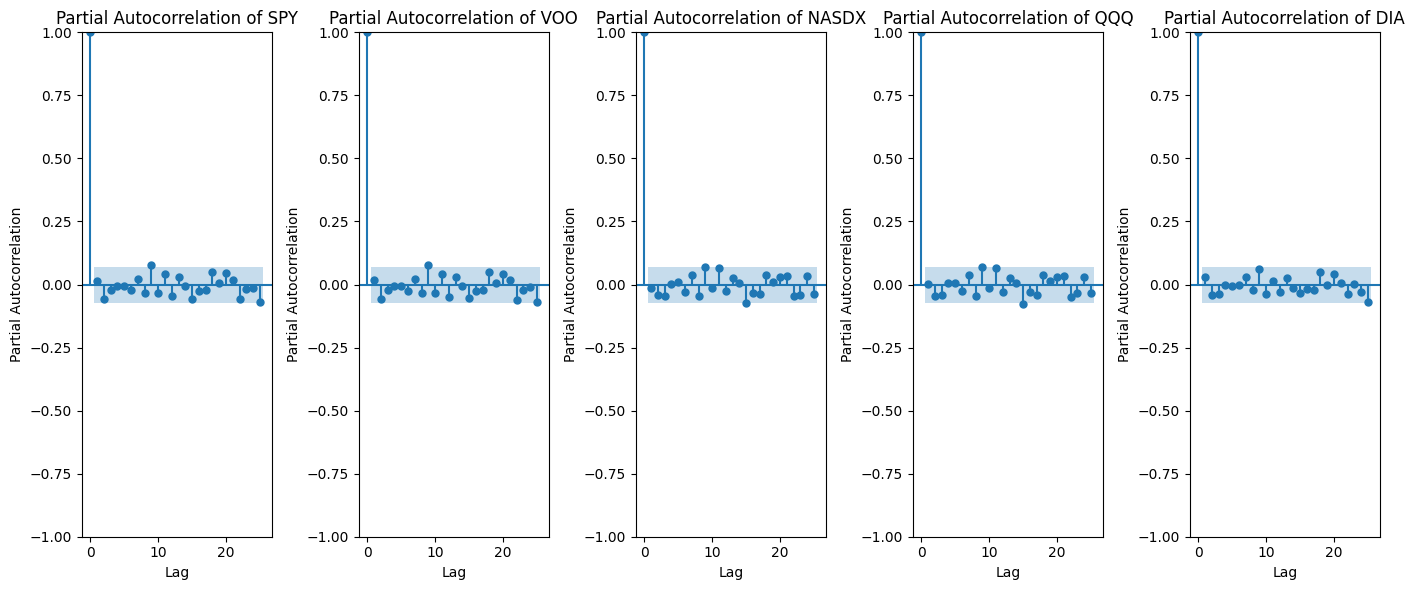

In [70]:
# PACF plots
fig, ax = plt.subplots(1, NUM_TICKERS, figsize= (14, 6))

for i, ticker in enumerate(tickers):
  plot_pacf(data[ticker].diff(periods=1).dropna(), ax = ax[i], lags = 25)
  ax[i].set(title = f'Partial Autocorrelation of {ticker}', xlabel = 'Lag', ylabel = 'Partial Autocorrelation')

plt.tight_layout()
plt.show()

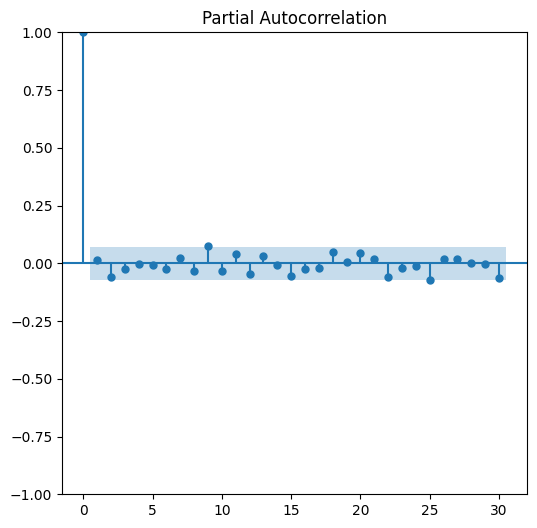

In [71]:
fig, ax = plt.subplots(figsize=(6,6))
fig = plot_pacf(spy_data.diff(periods=1).dropna(), lags = 30, ax = ax)

For SPY, we notice that there are no significant PACF values, so and AR model would probably not be appropriate.

Stationary Tests (Dicky-Fuller)

In [72]:
# Conduct ADF Test on all tickers
for ticker in tickers:
  print(f"ADF Test for {ticker}")
  perform_adf_test(data[ticker].values)
  print()

ADF Test for SPY
ADF Statistic: -0.705259
p-value: 0.845383

ADF Test for VOO
ADF Statistic: -0.686588
p-value: 0.850193

ADF Test for NASDX
ADF Statistic: -0.735844
p-value: 0.837245

ADF Test for QQQ
ADF Statistic: -0.697548
p-value: 0.847384

ADF Test for DIA
ADF Statistic: -0.863056
p-value: 0.799895



All time series were not stationary, which is needed for the models we will use. To fix this, we use first difference

# Modelling

## Data Preparation

In [73]:
transformed_data = data.copy()
transformed_data = transform_data(transformed_data)

In [74]:
# Conduct ADF Test on all tickers
for ticker in tickers:
  print(f"ADF Test for {ticker}")
  perform_adf_test(transformed_data[ticker].values)
  print()

ADF Test for SPY
ADF Statistic: -20.339119
p-value: 0.000000

ADF Test for VOO
ADF Statistic: -20.303244
p-value: 0.000000

ADF Test for NASDX
ADF Statistic: -27.783414
p-value: 0.000000

ADF Test for QQQ
ADF Statistic: -27.399310
p-value: 0.000000

ADF Test for DIA
ADF Statistic: -26.594045
p-value: 0.000000



In [75]:
TRAIN_END = datetime(2023, 2, 1) # date to train the model until
TEST_END = datetime(2023, 2, 8) # date to start forecasting after

In [76]:
spy_train, spy_test = split_data(transformed_data, 'SPY', TRAIN_END, TEST_END)
og_spy_train, og_spy_test = split_data(data, 'SPY', TRAIN_END, TEST_END)

Testing undo_transformations() function

In [77]:
test_transformed_values = undo_transformations(spy_train, pd.Series(og_spy_train.iloc[0]))

In [78]:
assert (og_spy_train[1:].values == test_transformed_values).all()

## Model Fitting & Evaluation

In [79]:
model = ARIMA(spy_train, order = (9,0,0))
fitted_model = model.fit()

In [80]:
results = evaluate_model(fitted_model, spy_test, spy_train, og_spy_train, og_spy_test)

MAE: 2.575989321421639
BIC: 2695.29787405166
AIC: 2650.519759043633


In [81]:
og_spy_train.index = og_spy_train.index.to_timestamp()

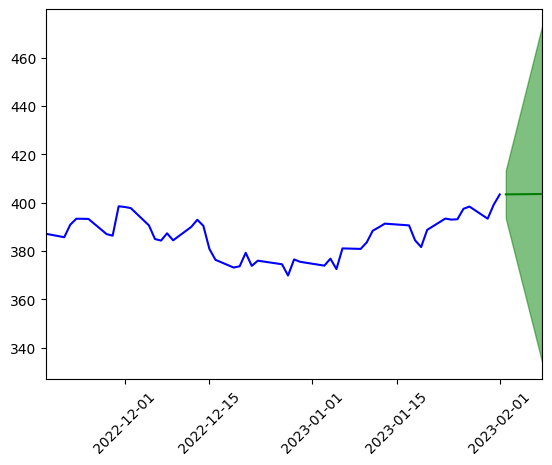

In [82]:
fig, ax = plt.subplots()

ax.plot(og_spy_train, color = 'b')
plt.xlim(og_spy_train.index[-50], TEST_END);
ax.plot(results.predicted, color = 'g')
plt.fill_between(results.index, results.lower_bound, results.upper_bound, color='g', alpha=0.5)
plt.xticks(rotation = 45);